Found 410 original attribution files in results/val/attributions
Found 410 steered attribution files in results/val_weighted/attributions
Found 410 matching attribution file pairs
Found 410 attribution pairs for analysis

=== ENTROPY ANALYSIS ===
Mean steered entropy: 14.1305
Mean original entropy: 14.1304
Mean difference (steered - original): 0.0001
Effect size: 0.0353
Wilcoxon test p-value: 0.032447
→ Steered attributions have HIGHER entropy (more dispersed)

=== SPARSITY ANALYSIS ===
Mean steered sparsity: 0.0245
Mean original sparsity: 0.0245
Mean difference: 0.0000
Wilcoxon test p-value: 0.196358

=== CONCENTRATION ANALYSIS ===
Mean Gini difference (steered - original): 0.0000
Mean top-10% concentration difference: -0.0000

=== DISTRIBUTION ANALYSIS ===
Mean JS divergence: 0.0010
Mean std difference: -0.0000
Mean skewness difference: -0.0001
Mean kurtosis difference: -0.0002

=== SPATIAL ANALYSIS ===
Mean spatial spread difference: 0.0087
Mean center-of-mass distance: 0.0517

=== 

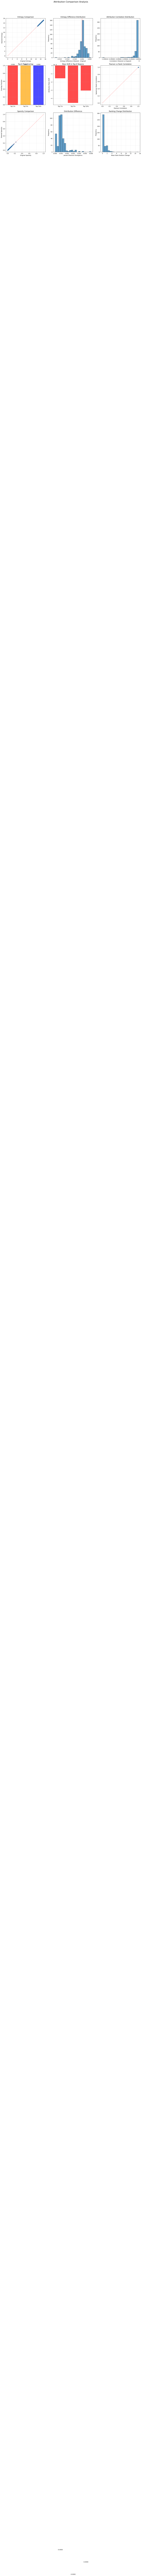


ATTRIBUTION COMPARISON ANALYSIS SUMMARY

KEY FINDINGS:
• Steered attributions are more concentrated (entropy Δ: -0.7113)
• High similarity between steered/original (r=1.000)
• Small distribution differences (JS divergence: 0.001)

RANKING SENSITIVITY (explains faithfulness differences):

💡 FAITHFULNESS INSIGHT:
   Although correlations are high (1.0000),
   ranking changes of 0.2% in top-1% pixels can significantly affect
   faithfulness metrics that depend on pixel importance ordering!
• Entropy differences are significant (p = 0.0324)

Top-1% pixel overlap: 0.998
Attribution mass shift in top-1%: -0.0000
Mean rank position changes: 0.7


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Optional, Callable
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def analyze_entropy_differences_per_class(
    results_dir: str = "./results/",
    original_dir_name: str = "val",
    steered_dir_name: str = "val_weighted",
    class_extractor: Optional[Callable[[str], str]] = None,
    save_plots: bool = True,
    verbose: bool = True
) -> Dict[str, any]:
    """
    Simple entropy-focused analysis comparing steered vs original attributions per class.
    
    Args:
        results_dir: Base results directory
        original_dir_name: Directory with original attributions  
        steered_dir_name: Directory with steered attributions
        class_extractor: Function to extract class from filename
        save_plots: Whether to save plots
        verbose: Whether to print results
    
    Returns:
        Dictionary with entropy analysis results
    """
    
    # Setup paths
    base_path = Path(results_dir)
    original_dir = base_path / original_dir_name / "attributions"
    steered_dir = base_path / steered_dir_name / "attributions"
    
    if not original_dir.exists() or not steered_dir.exists():
        print(f"Directories not found: {original_dir} or {steered_dir}")
        return {}
    
    # Load attribution pairs
    pairs = load_attribution_pairs(original_dir, steered_dir, verbose)
    if not pairs:
        return {}
    
    # Extract classes
    if class_extractor is None:
        class_extractor = default_class_extractor
    
    for pair in pairs:
        pair['class'] = class_extractor(pair['image_name'])
    
    # Calculate entropy for all pairs
    for pair in pairs:
        pair['original_entropy'] = calculate_entropy(pair['original_attribution'])
        pair['steered_entropy'] = calculate_entropy(pair['steered_attribution'])
        pair['entropy_difference'] = pair['steered_entropy'] - pair['original_entropy']
    
    # Overall analysis
    overall_results = analyze_overall_entropy(pairs, verbose)
    
    # Per-class analysis
    per_class_results = analyze_per_class_entropy(pairs, verbose)
    
    # Combine results
    results = {
        'overall': overall_results,
        'per_class': per_class_results,
        'raw_data': pairs
    }
    
    # Create visualization
    if save_plots:
        plot_path = str(base_path / f"entropy_analysis_{original_dir_name}_vs_{steered_dir_name}.png")
        create_entropy_plots(results, plot_path)
        results['plot_path'] = plot_path
    
    return results

def calculate_entropy(attribution_map: np.ndarray) -> float:
    """Calculate Shannon entropy of attribution map."""
    # Flatten and normalize to probability distribution
    flat_attr = np.abs(attribution_map.flatten())  # Use absolute values
    
    if flat_attr.sum() == 0:
        return 0.0
    
    # Normalize to probability distribution
    prob_dist = flat_attr / flat_attr.sum()
    
    # Remove zeros to avoid log(0)
    prob_dist = prob_dist[prob_dist > 0]
    
    # Calculate Shannon entropy
    return -np.sum(prob_dist * np.log2(prob_dist))

def load_attribution_pairs(original_dir: Path, steered_dir: Path, verbose: bool = True) -> List[Dict]:
    """Load matching attribution files from both directories."""
    
    original_files = list(original_dir.glob("*_attribution.npy"))
    steered_files = list(steered_dir.glob("*_attribution.npy"))
    
    if verbose:
        print(f"Found {len(original_files)} original and {len(steered_files)} steered attribution files")
    
    # Create filename mappings
    original_dict = {f.name: f for f in original_files}
    steered_dict = {f.name: f for f in steered_files}
    
    # Find common files
    common_files = set(original_dict.keys()) & set(steered_dict.keys())
    
    if verbose:
        print(f"Found {len(common_files)} matching pairs")
    
    pairs = []
    for filename in common_files:
        try:
            original_attr = np.load(original_dict[filename])
            steered_attr = np.load(steered_dict[filename])
            
            if original_attr.shape == steered_attr.shape:
                image_name = filename.replace("_attribution.npy", "")
                pairs.append({
                    'image_name': image_name,
                    'filename': filename,
                    'original_attribution': original_attr,
                    'steered_attribution': steered_attr
                })
            else:
                if verbose:
                    print(f"Shape mismatch for {filename}")
        except Exception as e:
            if verbose:
                print(f"Error loading {filename}: {e}")
    
    return pairs

def default_class_extractor(image_name: str) -> str:
    """Extract class from image filename using common patterns."""
    
    # Common class names to look for
    known_classes = [
        'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc',  # Skin lesions
        'cecum', 'ileum', 'retroflex-rectum', 'hemorrhoids', 'polyps', 'ulcerative-colitis',  # Endoscopy
        'anatomical', 'pathological', 'quality', 'artifact'  # General medical
    ]
    
    image_lower = image_name.lower()
    
    # Try class at beginning: "akiec_image_123" -> "akiec"
    parts = image_name.split('_')
    if len(parts) > 1 and parts[0].lower() in known_classes:
        return parts[0].lower()
    
    # Look for known class names anywhere
    for class_name in known_classes:
        if class_name in image_lower:
            return class_name
    
    # Fallback: first part before underscore
    if '_' in image_name:
        return parts[0].lower()
    
    return 'unknown'

def analyze_overall_entropy(pairs: List[Dict], verbose: bool = True) -> Dict:
    """Analyze entropy differences across all images."""
    
    original_entropies = [pair['original_entropy'] for pair in pairs]
    steered_entropies = [pair['steered_entropy'] for pair in pairs]
    entropy_diffs = [pair['entropy_difference'] for pair in pairs]
    
    # Statistical test
    stat, p_value = stats.wilcoxon(steered_entropies, original_entropies)
    
    results = {
        'n_samples': len(pairs),
        'mean_original_entropy': np.mean(original_entropies),
        'mean_steered_entropy': np.mean(steered_entropies),
        'mean_entropy_difference': np.mean(entropy_diffs),
        'std_entropy_difference': np.std(entropy_diffs),
        'median_entropy_difference': np.median(entropy_diffs),
        'wilcoxon_p_value': p_value,
        'effect_size': np.mean(entropy_diffs) / (np.std(entropy_diffs) + 1e-8)
    }
    
    if verbose:
        print(f"\n=== OVERALL ENTROPY ANALYSIS ===")
        print(f"Samples: {results['n_samples']}")
        print(f"Mean original entropy: {results['mean_original_entropy']:.4f}")
        print(f"Mean steered entropy: {results['mean_steered_entropy']:.4f}")
        print(f"Mean difference: {results['mean_entropy_difference']:.4f}")
        print(f"Std difference: {results['std_entropy_difference']:.4f}")
        print(f"Effect size: {results['effect_size']:.4f}")
        print(f"Wilcoxon p-value: {results['wilcoxon_p_value']:.6f}")
        
        if results['mean_entropy_difference'] > 0:
            print("→ Steered attributions have HIGHER entropy (more dispersed)")
        else:
            print("→ Steered attributions have LOWER entropy (more concentrated)")
    
    return results

def analyze_per_class_entropy(pairs: List[Dict], verbose: bool = True) -> Dict:
    """Analyze entropy differences for each class separately."""
    
    # Group by class
    class_groups = {}
    for pair in pairs:
        class_name = pair['class']
        if class_name not in class_groups:
            class_groups[class_name] = []
        class_groups[class_name].append(pair)
    
    if verbose:
        print(f"\n=== PER-CLASS ENTROPY ANALYSIS ===")
        print("Class distribution:")
        for class_name, class_pairs in class_groups.items():
            print(f"  {class_name}: {len(class_pairs)} samples")
    
    per_class_results = {}
    
    for class_name, class_pairs in class_groups.items():
        if len(class_pairs) < 3:  # Skip classes with too few samples
            continue
        
        original_entropies = [pair['original_entropy'] for pair in class_pairs]
        steered_entropies = [pair['steered_entropy'] for pair in class_pairs]
        entropy_diffs = [pair['entropy_difference'] for pair in class_pairs]
        
        # Statistical test (only if enough samples)
        p_value = None
        if len(class_pairs) >= 5:
            try:
                _, p_value = stats.wilcoxon(steered_entropies, original_entropies)
            except:
                p_value = None
        
        class_results = {
            'n_samples': len(class_pairs),
            'mean_original_entropy': np.mean(original_entropies),
            'mean_steered_entropy': np.mean(steered_entropies),
            'mean_entropy_difference': np.mean(entropy_diffs),
            'std_entropy_difference': np.std(entropy_diffs),
            'median_entropy_difference': np.median(entropy_diffs),
            'wilcoxon_p_value': p_value,
            'effect_size': np.mean(entropy_diffs) / (np.std(entropy_diffs) + 1e-8)
        }
        
        per_class_results[class_name] = class_results
        
        if verbose:
            print(f"\n{class_name} (n={class_results['n_samples']}):")
            print(f"  Mean entropy difference: {class_results['mean_entropy_difference']:.4f}")
            print(f"  Effect size: {class_results['effect_size']:.4f}")
            if p_value is not None:
                print(f"  p-value: {p_value:.6f}")
    
    # Find most/least affected classes
    if len(per_class_results) > 1:
        entropy_diffs_by_class = {k: v['mean_entropy_difference'] for k, v in per_class_results.items()}
        most_affected = max(entropy_diffs_by_class.items(), key=lambda x: abs(x[1]))
        least_affected = min(entropy_diffs_by_class.items(), key=lambda x: abs(x[1]))
        
        if verbose:
            print(f"\n--- CLASS COMPARISON ---")
            print(f"Most affected: {most_affected[0]} (Δ={most_affected[1]:.4f})")
            print(f"Least affected: {least_affected[0]} (Δ={least_affected[1]:.4f})")
            
            # Calculate variance across classes
            all_diffs = list(entropy_diffs_by_class.values())
            class_variance = np.var(all_diffs)
            print(f"Inter-class variance: {class_variance:.6f}")
            
            if class_variance > 0.0001:
                print("→ HIGH variance: Steering affects classes differently!")
            else:
                print("→ Low variance: Steering affects classes similarly")
        
        per_class_results['_summary'] = {
            'most_affected_class': most_affected[0],
            'most_affected_difference': most_affected[1],
            'least_affected_class': least_affected[0], 
            'least_affected_difference': least_affected[1],
            'inter_class_variance': np.var(list(entropy_diffs_by_class.values()))
        }
    
    return per_class_results

def create_entropy_plots(results: Dict, save_path: str):
    """Create focused entropy visualization plots."""
    
    if not results['per_class']:
        return
    
    # Extract data for plotting
    class_names = [k for k in results['per_class'].keys() if not k.startswith('_')]
    class_data = {k: results['per_class'][k] for k in class_names}
    
    entropy_diffs = [class_data[k]['mean_entropy_difference'] for k in class_names]
    effect_sizes = [class_data[k]['effect_size'] for k in class_names]
    n_samples = [class_data[k]['n_samples'] for k in class_names]
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Entropy Analysis: Steered vs Original Attributions', fontsize=16)
    
    # 1. Overall entropy difference distribution
    ax = axes[0, 0]
    all_diffs = [pair['entropy_difference'] for pair in results['raw_data']]
    ax.hist(all_diffs, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
    ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.axvline(np.mean(all_diffs), color='orange', linestyle='-', alpha=0.7, linewidth=2, label=f'Mean: {np.mean(all_diffs):.4f}')
    ax.set_xlabel('Entropy Difference (Steered - Original)')
    ax.set_ylabel('Frequency')
    ax.set_title('Overall Entropy Difference Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Per-class entropy differences
    ax = axes[0, 1]
    colors = ['red' if x > 0 else 'blue' for x in entropy_diffs]
    bars = ax.bar(range(len(class_names)), entropy_diffs, color=colors, alpha=0.7)
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylabel('Mean Entropy Difference')
    ax.set_title('Entropy Change by Class')
    ax.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, entropy_diffs)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.001 if val >= 0 else -0.003),
               f'{val:.4f}', ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)
    
    # 3. Effect sizes by class
    ax = axes[1, 0]
    bars = ax.bar(range(len(class_names)), effect_sizes, alpha=0.7, color='green')
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylabel('Effect Size')
    ax.set_title('Effect Size by Class')
    ax.grid(True, alpha=0.3)
    
    # 4. Effect size vs sample size
    ax = axes[1, 1]
    scatter = ax.scatter(n_samples, effect_sizes, s=100, alpha=0.7, c=range(len(class_names)), cmap='tab10')
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Effect Size')
    ax.set_title('Effect Size vs Sample Size')
    ax.grid(True, alpha=0.3)
    
    # Add class labels to scatter plot
    for i, class_name in enumerate(class_names):
        ax.annotate(class_name, (n_samples[i], effect_sizes[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plots saved to: {save_path}")

# Simple usage example
def test_entropy_analysis():
    """Test with synthetic data."""
    import tempfile
    
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create test directories
        original_dir = Path(temp_dir) / "val" / "attributions"
        steered_dir = Path(temp_dir) / "val_weighted" / "attributions"
        original_dir.mkdir(parents=True)
        steered_dir.mkdir(parents=True)
        
        # Create synthetic data with class-specific patterns
        class_names = ['mel', 'nv', 'bcc']
        for i in range(15):
            class_name = class_names[i % len(class_names)]
            filename = f"{class_name}_image_{i:03d}_attribution.npy"
            
            # Original attribution
            original = np.random.rand(64, 64) * 0.5
            
            # Steered with class-dependent effects
            steered = original.copy()
            if class_name == 'mel':  # Melanoma: more concentrated
                steered += np.random.rand(64, 64) * 0.2
                steered[20:40, 20:40] += 0.5  # Concentrated region
            elif class_name == 'nv':  # Nevus: more dispersed  
                steered += np.random.rand(64, 64) * 0.8
            else:  # BCC: minimal change
                steered += np.random.rand(64, 64) * 0.1
            
            np.save(original_dir / filename, original)
            np.save(steered_dir / filename, steered)
        
        # Run analysis
        results = analyze_entropy_differences_per_class(
            results_dir=temp_dir,
            save_plots=False,
            verbose=True
        )
        
        return results

if __name__ == "__main__":
    results = analyze_entropy_differences_per_class(
        results_dir="./results/",
        original_dir_name="val",
        steered_dir_name="val_weighted",
        save_plots=True,
        verbose=True
    )

    # Check which classes are most affected
    if 'per_class' in results and '_summary' in results['per_class']:
        summary = results['per_class']['_summary']
        print(f"Focus on {summary['most_affected_class']} - shows biggest entropy changes")
        print(f"Inter-class variance: {summary['inter_class_variance']}")